In [14]:
import ast
import pandas as pd
import numpy as np
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import tensorflow.random as random

seed = 111
random.set_seed(seed)
np.random.seed(seed)

In [2]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [3]:
df = pd.read_csv("cleaned_data/cleaned_reviews_4.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,"This started out strong, but it went downhill ...","[start, out, strong, but, go, downhill, fairly...",1,0,start out strong but go downhill fairly quickl...
1,"A decently written YA book, but I can't even c...","[decently, write, ya, book, but, can, even, co...",1,0,decently write ya book but can even consider e...
2,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...
3,I hate to give any book this low of a rating -...,"[hate, give, any, book, low, rat, know, take, ...",1,0,hate give any book low rat know take actually ...
4,Main points: \n 1. Never ever introduce a poin...,"[main, point, never, ever, introduce, point, v...",1,0,main point never ever introduce point view sid...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     11400 non-null  object
 1   text       11400 non-null  object
 2   rating     11400 non-null  int64 
 3   sentiment  11400 non-null  int64 
 4   detoken    11400 non-null  object
dtypes: int64(2), object(3)
memory usage: 445.4+ KB


In [4]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 222)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")

There are 1293014 train words in total and the vocabulary size is 29866.


In [5]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# max_length = max(max([len(x) for x in train_sequences]), max([len(x) for x in test_sequences]))
max_length = 100

x_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(max_length)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

100
(11200, 100)
(2800, 100)
(11200,)
(2800,)
Found 29900 unique tokens


In [6]:
vocab_train = vocab_build(df_train["text"])
vocab_test = vocab_build(df_test["text"])

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"], embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in testing set")

Glove embeddings cover 95.22% of vocabulary and 99.79% text in training set
Glove embeddings cover 97.13% of vocabulary and 99.76% text in testing set


In [7]:
EMBEDDING_DIM = 300
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=False)

del(embedding_matrix)

#### CNN + GRU

In [18]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(4))
model.add(GRU(32))
# model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_5 (Conv1D)           (None, 97, 32)            38432     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                      

In [19]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 8s 41ms/step - loss: 0.6085 - accuracy: 0.6676 - val_loss: 0.7203 - val_accuracy: 0.7580
Epoch 2/5
140/140 [==============================] - 4s 25ms/step - loss: 0.3673 - accuracy: 0.8379 - val_loss: 0.3576 - val_accuracy: 0.8562
Epoch 3/5
140/140 [==============================] - 3s 21ms/step - loss: 0.2871 - accuracy: 0.8816 - val_loss: 0.7795 - val_accuracy: 0.6496
Epoch 4/5
140/140 [==============================] - 3s 21ms/step - loss: 0.2260 - accuracy: 0.9105 - val_loss: 0.3396 - val_accuracy: 0.8576
Epoch 5/5
140/140 [==============================] - 3s 21ms/step - loss: 0.1746 - accuracy: 0.9325 - val_loss: 0.6112 - val_accuracy: 0.7647


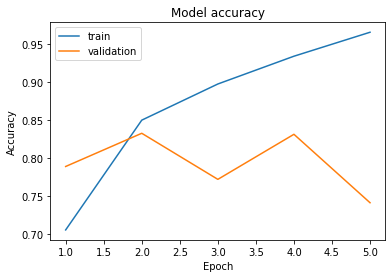

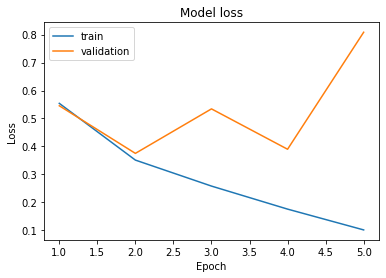

88/88 - 1s - loss: 0.4994 - accuracy: 0.8389 - 770ms/epoch - 9ms/step
Test accuracy: 0.8389285802841187
Confusion matrix: 
 [[1034  366]
 [  85 1315]]
Test accuracy: 0.8389285714285715


In [10]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### CNN + LSTM

In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(4))
model.add(LSTM(32))
# model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 32)            38432     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 50)                16600     
                                                                 
 dense_14 (Dense)            (None, 16)                816       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                      

In [28]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.2)

Epoch 1/5
140/140 [==============================] - 7s 38ms/step - loss: 0.5092 - accuracy: 0.7439 - val_loss: 0.5701 - val_accuracy: 0.7897
Epoch 2/5
140/140 [==============================] - 5s 32ms/step - loss: 0.3448 - accuracy: 0.8527 - val_loss: 0.3133 - val_accuracy: 0.8741
Epoch 3/5
140/140 [==============================] - 5s 33ms/step - loss: 0.2919 - accuracy: 0.8795 - val_loss: 0.5036 - val_accuracy: 0.7951
Epoch 4/5
140/140 [==============================] - 5s 33ms/step - loss: 0.2203 - accuracy: 0.9151 - val_loss: 0.4930 - val_accuracy: 0.7897
Epoch 5/5
140/140 [==============================] - 5s 34ms/step - loss: 0.1740 - accuracy: 0.9368 - val_loss: 0.3722 - val_accuracy: 0.8371


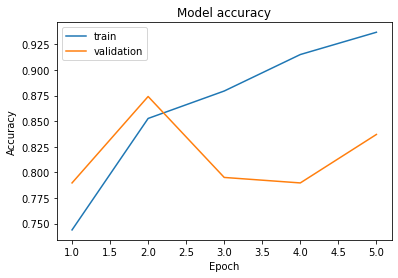

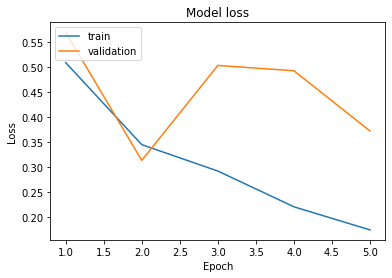

88/88 - 1s - loss: 0.3373 - accuracy: 0.8679 - 725ms/epoch - 8ms/step
Test accuracy: 0.8678571581840515
Confusion matrix: 
 [[1197  203]
 [ 167 1233]]
Test accuracy: 0.8678571428571429


In [29]:
# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")